In [11]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
from torch.autograd import Variable
import math
import numpy as np
from natsort import natsorted
from PIL import Image
import random

In [2]:
# Code to upload dataset to google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

path_to_zip_file = 'drive/MyDrive/data.zip'
directory_to_extract_to = 'data/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [26]:
class VISCHEMA_PLUS(Dataset):
    def __init__(self, image_dir = 'data/images', label_dir = 'data/vms', transform = None):
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        
        all_images = os.listdir(image_dir)
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.image_dir}/{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.label_dir}/{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

# I have resized the images to 512x512 as this will make designing the model easier.
image_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(0.5,0.5)
])
        
dataset = VISCHEMA_PLUS(transform = image_transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(test_dataset)}  Items in Test dataset')

1280 Items in Train dataset
320  Items in Test dataset


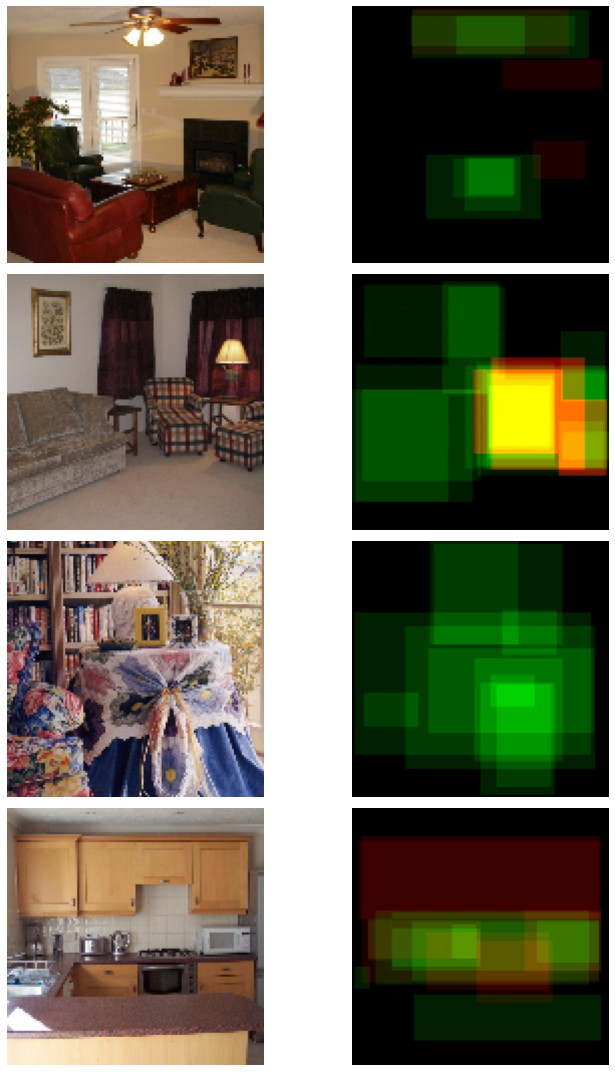

In [27]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(15,15))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [31]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,out_channels,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512)):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(512,256,128,64)):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class Generator(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512), 
                 decode_channels=(512,256,128,64), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572)):
        
        super(Generator, self).__init__()
        
        self.encoder = Encoder(encode_channels)
        self.decoder = Decoder(decode_channels)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""

    def forward(self, x):
        
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)
        output = nn.Tanh()(output)
        
        return output

model = Generator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet Generator')

images, _ = next(iter(train_loader))
output = model(images)
print(output.shape)

del model, output, images

7703107 Parameters in UNet Generator
torch.Size([4, 3, 128, 128])


In [33]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def block(in_channels, out_channels, norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4,stride=2, padding=1)]
            if norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(6, 64, norm = False),
            *block(64, 128),
            *block(128,256),
            *block(256,512),
            *block(512,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512,1,4,padding=1, bias=False)
        )
        
    def forward(self, images, labels):
        
        image_input = torch.cat((images, labels), 1)
        return self.model(image_input)

model = Discriminator()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in Discriminator')

images, labels = next(iter(train_loader))
output = model(images, labels)
print(output.shape)

del model, output, images

6965440 Parameters in Discriminator
torch.Size([4, 1, 4, 4])


In [44]:
# Set up our training environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch = (1, 4, 4)

net_G = Generator()
net_D = Discriminator()

net_G, net_D = net_G.to(device), net_D.to(device)

criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss() 

# Loss weight of L1 pixel-wise loss between translated image and real image
# This value is copied from the PIX2PIX architecture
lambda_pixel = 100

optim_G = torch.optim.Adam(net_G.parameters(), lr=0.0001, betas = (0,0.9))
optim_D = torch.optim.Adam(net_D.parameters(), lr=0.0001, betas = (0,0.9))
num_epochs = 250

In [46]:
print('Starting Training')
for epoch in range(num_epochs):
    
    # Go into training mode
    net_D.train()
    net_G.train()
    
    # Train the model and evaluate on the training set
    total_train_loss = 0
    total_test_loss = 0

    for i, (images, real_labels) in enumerate(train_loader):

        # Adversarial ground truths
        valid = torch.ones((images.size(0), *patch)).to(device)
        fake = torch.zeros((images.size(0), *patch)).to(device)

        # Move images to device and create an image prediction
        images, real_labels = images.to(device), real_labels.to(device)
        
        ###################
        # Train Generator #
        ###################

        optim_G.zero_grad()
        
        # GAN Loss
        
        fake_labels = net_G(images)
        pred_fake = net_D(fake_labels, images)
        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_pixel = criterion_pixelwise(fake_labels, real_labels)
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        
        loss_G.backward()
        optim_G.step()
        
        #######################
        # Train Discriminator #
        #######################

        optim_D.zero_grad()
        
        # Real Loss
        pred_real = net_D(real_labels, images)
        loss_real = criterion_GAN(pred_real, valid)
        
        # Fake Loss
        pred_fake = net_D(fake_labels.detach(), images)
        loss_fake = criterion_GAN(pred_fake, fake)
        
        # Total Loss
        loss_D = 0.5 * (loss_real + loss_fake)
        
        loss_D.backward()
        optim_D.step()

        # Clear memory
        del images, real_labels, fake_labels 
        torch.cuda.empty_cache() 
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

    if epoch % 25 == 0:
      torch.save(net_D.state_dict(), f'weights-NETD-1-{epoch}.pkl')
      torch.save(net_G.state_dict(), f'weights-NETG-1-{epoch}.pkl')

Starting Training
Epoch [1/250], Loss D: 0.0107, Loss G: 36.2403
Epoch [2/250], Loss D: 0.0124, Loss G: 22.7705
Epoch [3/250], Loss D: 0.0043, Loss G: 18.8088
Epoch [4/250], Loss D: 0.0063, Loss G: 16.1319
Epoch [5/250], Loss D: 0.0085, Loss G: 14.6234
Epoch [6/250], Loss D: 0.0049, Loss G: 15.7809
Epoch [7/250], Loss D: 0.0066, Loss G: 14.3285
Epoch [8/250], Loss D: 0.0171, Loss G: 12.8479
Epoch [9/250], Loss D: 0.0013, Loss G: 15.0608
Epoch [10/250], Loss D: 0.0060, Loss G: 15.2742
Epoch [11/250], Loss D: 0.0578, Loss G: 13.7088
Epoch [12/250], Loss D: 0.0059, Loss G: 10.7038
Epoch [13/250], Loss D: 0.0026, Loss G: 12.6315
Epoch [14/250], Loss D: 0.0024, Loss G: 15.0503
Epoch [15/250], Loss D: 0.0036, Loss G: 16.4459
Epoch [16/250], Loss D: 0.0038, Loss G: 13.5377
Epoch [17/250], Loss D: 0.0005, Loss G: 9.7189
Epoch [18/250], Loss D: 0.0054, Loss G: 18.4927
Epoch [19/250], Loss D: 0.0030, Loss G: 8.3936
Epoch [20/250], Loss D: 0.0011, Loss G: 12.3303
Epoch [21/250], Loss D: 0.0027, L

KeyboardInterrupt: ignored

In [47]:
torch.save(net_D.state_dict(), f'weights-NETD-1-{epoch}.pkl')
torch.save(net_G.state_dict(), f'weights-NETG-1-{epoch}.pkl')

In [ ]:
# Visualise Output

net_G = Generator()
net_G.load_state_dict(torch.load("weights-NETG-1-48.pkl", map_location=torch.device('cpu')), strict=False)

import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
figure = plt.figure(figsize=(15,15))
output = net_G(images)

cols, rows = 3, 4
for i in range(rows):

    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )
    
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((output[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )  

    figure.add_subplot(rows,cols, cols*i+3)
    plt.axis("off")
    plt.imshow((labels[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )
plt.tight_layout()
plt.show()